# Read in the data

In [47]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [48]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  This is separate from the ipykernel package so we can avoid doing imports until


# Add DBN columns

In [49]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [50]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [51]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [52]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [53]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [54]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [55]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [56]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
# Filter: Correlations between the survey fields and SAT score
survey_correlations = correlations[survey_fields]

Text(0.5,1,'Correlation of Survey Fields with SAT Scores')

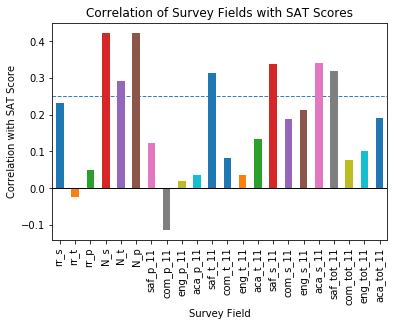

In [114]:
plt.axhline(0, 0, 1, lw = 1, color = 'black')
plt.axhline(.25, 0, 1, lw = 1, ls = 'dashed', color = '#377eb8', zorder = 1)
survey_correlations.plot.bar(x = 'Survey Field', y = 'Correlation', zorder = 2)
plt.xlabel('Survey Field')
plt.ylabel('Correlation with SAT Score')
plt.title('Correlation of Survey Fields with SAT Scores')

The survey fields with a correlation of over 0.25 with the SAT scores are: 
- N_s: Number of student respondents
- N_t: Number of teacher respondents
- N_p: Number of parent respondents
- saf_t_11: Safety and respect score based on teacher responses (grade 11)
- saf_s_11: Safety and respect score based on student responses (grade 11)
- aca_s_11: Academic expectations score based on student responses (grade 11)
- saf_tot_11: Safey and respect total score

There is a positive correlation between the SAT scores and the number of survey participants (students, parents, teachers). There is also a positive correlation between the SAT scores and student academic expectations. What is more surprising is the positive correlation between the SAT scores and safety and respect at the school, as reported by students and teachers alike.

## Exploring Safety and SAT Scores

Text(0.5,1,'Schools: Student Safety vs SAT')

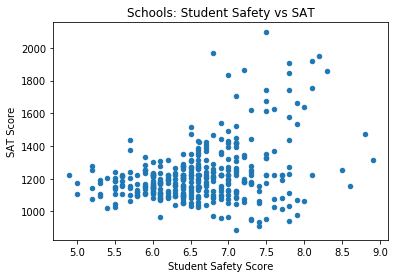

In [112]:
combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')
plt.xlabel('Student Safety Score')
plt.ylabel('SAT Score')
plt.title('Schools: Student Safety vs SAT')

There is a weak positive correlation between safety and SAT scores. What is notable is the cluster at the safety scores from 5 to 8 and SAT scores from 1000 to 1400.

### Map Out Safety Scores

In [61]:
# Compute the average safety score for each district
districts = combined.groupby('school_dist').agg(numpy.mean)

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


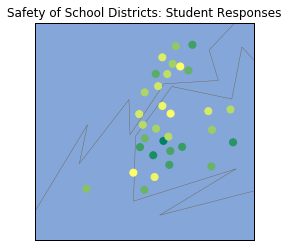

In [62]:
# Make a map that shows safety scores by district

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='l'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s = 50, zorder = 2, latlon = True,
          c = districts["saf_s_11"], cmap = "summer")
plt.title('Safety of School Districts: Student Responses')
plt.show()

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


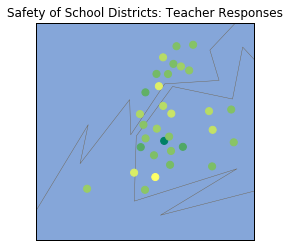

In [63]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='l'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s = 50, zorder = 2, latlon = True,
          c = districts["saf_t_11"], cmap = "summer")
plt.title('Safety of School Districts: Teacher Responses')
plt.show()

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


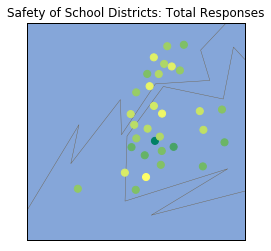

In [64]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='l'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s = 50, zorder = 2, latlon = True,
          c = districts["saf_tot_11"], cmap = "summer")
plt.title('Safety of School Districts: Total Responses')
plt.show()

A few of the school districts with the lowest safety scores, according to the surveys, are located in Manhattan and the Bronx, followed by a few in Queens. Brooklyn has relatively higher safety scores.

## Exploring Race and SAT Scores

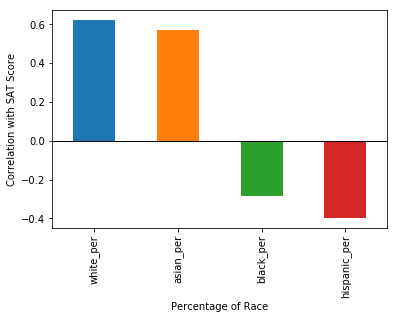

In [113]:
# Percentage of each race at a given school
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
race_correlations = correlations[race_cols]

race_correlations.plot.bar(x = 'Race', y = 'Correlation')
plt.xlabel('Percentage of Race')
plt.ylabel('Correlation with SAT Score')
plt.axhline(0, 0, 1, lw = 1, color = 'black')

There is a positive correlation between the percentage of white students at a given school and the SAT score. The same can be said for the percentage of Asian students.

There is a negative correlation between the percentage of black students at a given school and the SAT score. The same can be said for the percentage of Hispanic students. It is likely these schools may have a lack of funding.

### Relationship Between Hispanic Percentage and SAT Scores

Text(0.5,1,'Schools: Hispanic Percentage vs SAT Scores')

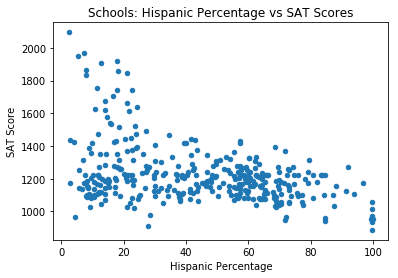

In [116]:
combined.plot.scatter(x = 'hispanic_per', y = 'sat_score')
plt.xlabel('Hispanic Percentage')
plt.ylabel('SAT Score')
plt.title('Schools: Hispanic Percentage vs SAT Scores')

There appears to be a negative correlation between the SAT score and the percentage of Hispanic students at a school. There is a sharp decline in SAT scores with percentage up to 20% before the SAT scores are relatively constant with percentage.

In [67]:
# Look at schools with hispanic_per > 95%
combined.loc[combined['hispanic_per'] > 95, 'SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above are attended by immigrant students who recently came to the US. These students are learning English at school, which would explain their lower SAT scores.

In [68]:
# Look at schools with hispanic_per < 10% and avg. SAT > 1800
school_condition = (combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)
combined.loc[school_condition, 'SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The school listed above are specialized schools, with a focus on maths and sciences. While these schools are public schools, they can be classified as "elite" schools. These schools require examination for admission (high scores on the Specialized High Schools Admissions Test). These schools are likely to receive significant funding, which can explain the high SAT scores. We do not want to make a conclusion about race, although there have been concerns of an inherent bias of this admission process against certain demographics.

## Exploring Gender and SAT Scores

Text(0,0.5,'Correlation with SAT Scores')

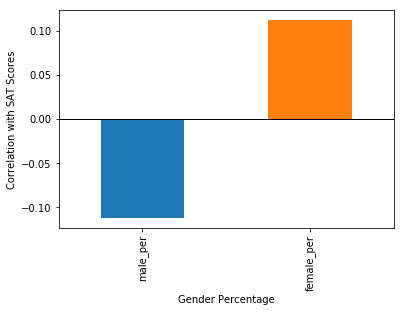

In [117]:
gender_correlation = correlations[['male_per', 'female_per']]

gender_correlation.plot.bar(x = 'Gender Percentage', y = 'Correlation')
plt.axhline(0, 0, 1, lw = 1, color = 'black')
plt.xlabel('Gender Percentage')
plt.ylabel('Correlation with SAT Scores')

There is a negative correlation between the percentage of male students at a school and the school's SAT score. There is a positive correlation between the percentage of female students at a school and the school's SAT score. That said, correlations are weak, or arguably non-existent (absolute values are below 0.25).

### High Female Attendance vs. SAT Scores

Text(0.5,1,'Female Attendance vs SAT Scores')

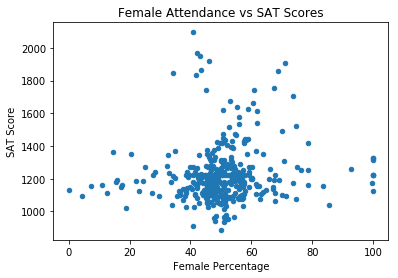

In [118]:
combined.plot.scatter(x = 'female_per', y = 'sat_score')
plt.xlabel('Female Percentage')
plt.ylabel('SAT Score')
plt.title('Female Attendance vs SAT Scores')

There does not seem to be a strong correlation, if at all, between the percentage of female students and the SAT scores. That said, there appears to be a spike in SAT scores at roughly 40 to 50% female students, along with a few schools with high SAT scores from 60 to 80%.

In [71]:
# Look up schools with female_per > 60% and average SAT score 1700
school_condition_2 = (combined['female_per'] > 60) & (combined['sat_score'] > 1700)
combined.loc[school_condition_2, 'SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The five schools listed above are magnet or specialized schools with strong college-preparatory programs (Bard High School Early College actually provides 11th and 12th grade students with college-level courses). The schools are selective with strong liberal arts programs.

## Exploring AP Scores vs SAT Scores

In [72]:
# First, get percentage of students who took AP exam
# Don't look at absolute value, as total_enrollment is highly correlated with sat_score

combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

Text(0,0.5,'SAT Scores')

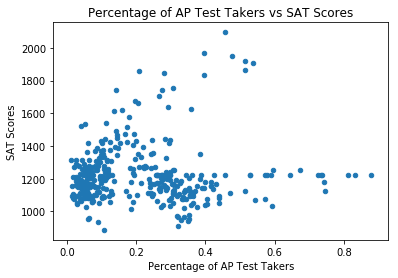

In [119]:
combined.plot.scatter(x = 'ap_per', y = 'sat_score')
plt.title('Percentage of AP Test Takers vs SAT Scores')
plt.xlabel('Percentage of AP Test Takers')
plt.ylabel('SAT Scores')

There is some positive correlation between the percentage of students taking AP exams and SAT scores. There is, however, a cluster of schools with an average SAT score of around 1200 in spite of high percentages of students taking AP exams. 

The fact that students take AP exams does not necessarily point to academic success, as students can take AP exams and receive failing scores. The only barrier, in theory, to taking an AP exam is the cost of taking the exam.

## Exploring Class Size vs SAT Scores

In [78]:
class_size_col = correlations[['AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS']]

Text(0,0.5,'Correlation wiht SAT Score')

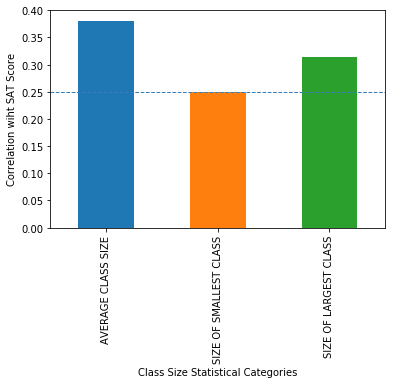

In [122]:
class_size_col.plot.bar()
plt.axhline(0, 0, 1, lw = 1, color = 'black')
plt.axhline(.25, 0, 1, lw = 1, ls = 'dashed', color = '#377eb8', zorder = 1)
plt.xlabel('Class Size Statistical Categories')
plt.ylabel('Correlation wiht SAT Score')

There is a positive correlation between the average class size and SAT scores. The "AVERAGE CLASS SIZE" Series is worth investigating versus "SIZE OF LARGEST CLASS". This goes against the expectation that smaller class sizes are correlated with higher SAT scores.

Text(0.5,1,'Schools: Average Class Size vs SAT Scores')

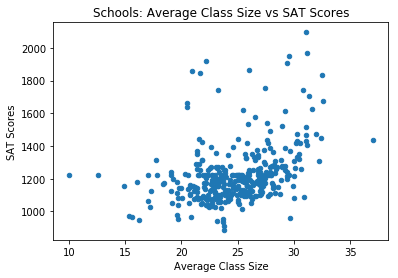

In [123]:
combined.plot.scatter(x = 'AVERAGE CLASS SIZE', y = 'sat_score')
plt.xlabel('Average Class Size')
plt.ylabel('SAT Scores')
plt.title('Schools: Average Class Size vs SAT Scores')

There is a slight positive correlation between class size and SAT scores, but the correlation is not necessarily strong. It is noted there is a large cluster (~160 schools) in the 20-30 range for class size and 1000-1200 range for SAT scores. Let us take a look at a few boundary cases.

In [84]:
size_condition_1 = (combined['AVERAGE CLASS SIZE'] > 25) & (combined['sat_score'] > 1800)

combined.loc[size_condition_1, 'SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above are specialized high schools, where the class sizes are, on average, 25 to 33.

In [85]:
combined.loc[combined['AVERAGE CLASS SIZE'] > 35, 'SCHOOL NAME']     # Avg class size > 35, SAT ~ 1450

17    NYC ISCHOOL
Name: SCHOOL NAME, dtype: object

In [88]:
combined.loc[17, ['hispanic_per', 'black_per']]    # The school has advertised diversity

hispanic_per      43
black_per       20.6
Name: 17, dtype: object

NYC ISCHOOL is also a selective high school with generally good ratings. It is noted for its more experimental approaches to education. The large class size may be part of this experimental approach. The experimental approach may be a factor towards the lower SAT scores.

In [89]:
combined.loc[combined['AVERAGE CLASS SIZE'] < 15, 'SCHOOL NAME']    # SAT ~ 1200

8                                ESSEX STREET ACADEMY
56        THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS
264    THE URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE
Name: SCHOOL NAME, dtype: object

The Urban Assembly School For Green Careers has specialized classes towards ecological sustainability, specifically training students for jobs in eco-friendly jobs in construction and agriculture. This focus may not reflect what is normally tested by the SAT. The small class size may reflect actual enrollment, or may reflect the notably high chronic absenteeism.

The Urban Assembly School for Criminal Justice is an all-girls school. One objective note about the school is relative low funding, which may be connected to the SAT scores. 

The Essex Street Academy's curriculum can also be characterized as experimental.

## Neighborhood Analysis

We will associate neighborhoods with school districts. Therefore, we will compare school districts with SAT scores.

Text(0.5,0,'School Districts')

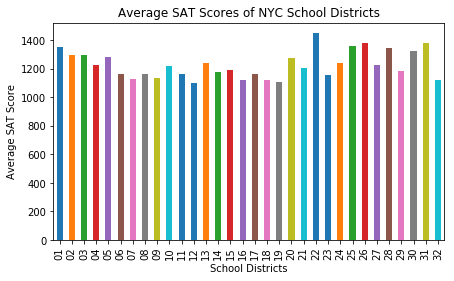

In [110]:
fig = plt.figure(figsize = (7,4))
districts['sat_score'].plot.bar()
plt.title('Average SAT Scores of NYC School Districts')
plt.ylabel('Average SAT Score')
plt.xlabel('School Districts')

In [131]:
sat_districts = districts.sort_values('sat_score', ascending = False)
sat_districts['sat_score'].head()

school_dist
22    1450.5
31    1382.5
26    1377.6
25    1357.0
01    1354.5
Name: sat_score, dtype: float64

The five school districts with the top five average SAT scores are 22, 31, 26, 25, and 01, in descending order. 
One source for housing costs in given districts in New York City is https://www.bloomberg.com/graphics/property-prices/nyc/, except for District 31.

- District 22 is located in Brooklyn. One of the neighborhoods in this District is Sheepshead Bay, which has had housing costs of \$200,000-400,000 in 2011. A few of the other neighborhoods in this district report housing costs of \$400,000-500,000 from 2014 to 2018.
- District 31 is the entirety of Staten Island. According to SIBOR, the median housing cost in Staten Island was about \$375,000 in 2011.
- District 26 is in Queens. Oakland Gardens, a neighborhood in this district, had a 2011 median housing cost from \$200,000 to \$250,000 until Q4 2011, when the median housing cost was \$166,800. Queens Village reported median housing costs from \$250,000 to \$366,000 in 2011.
- District 25 is in Queens. Flushing, a large neighborhood in this district, had median housing costs in the low \$200,000s in 2011. Whitestone, a neighborhood in this district, had a median housing cost of \$283,750 in Q3 2011.
- District 01 is in Manhattan. One of the neighborhoods in this district is East Village, which had median housing costs from \$680,000 to \$997,500 in 2011. Lower East Side/Chinatown may also be included in this district. The two reported values for median housing costs in 2011 are \$610,000 and \$800,000.

Of these top five school districts (using SAT scores as a metric), the least expensive districts were 25 and 26 in 2011. Flushing and Oakland Gardens were relatively inexpensive in 2011.

What if we had done this analysis differently? What if we looked at the top five schools (based on SAT scores) in 2011, and looked at the neighborhoods corresponding to the school districts these top five schools were in?

In [127]:
sat_schools = combined.sort_values('sat_score', ascending = False)
sat_schools[['SCHOOL NAME', 'school_dist', 'sat_score']].head()

,SCHOOL NAME,school_dist,sat_score
37,STUYVESANT HIGH SCHOOL,02,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,10,1969.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,31,1953.0
155,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,10,1920.0
302,TOWNSEND HARRIS HIGH SCHOOL,25,1910.0


- District 2 is in Manhattan. There are several neighborhoods located in this district, which makes up most of the borough. A few median housing costs in an assortment of neighborhoods (Midtown West, Greenwich Village, West Village, and Midtown South) are roughly \$570,000 to \$1.2 million in 2011.
- District 10 is in Bronx. Median housing costs were not reported for the Inwood/Marble Hill neighborhood in 2011. The median housing cost reported in Q2 2007 was \$342,250, and the next median housing cost was reported to be \$317,000 in Q3 2013.
- District 31 is the entirety of Staten Island. According to SIBOR, the median housing cost in Staten Island was about \$375,000 in 2011.
- District 25 is in Queens. Flushing, a large neighborhood in this district, had median housing costs in the low \$200,000s in 2011. Whitestone, a neighborhood in this district, had a median housing cost of \$283,750 in Q3 2011.

Looking at the top five schools, Townsend Harris High School is located in the least expensive school district, and Stuyvesant High School is located in the most expensive high school district. 

It is noted, however, that these schools may not represent their actual school districts, as these are all specialized schools. This was, perhaps, why there was value in looking at the average SAT scores per school district.